In [ ]:
### 只做单模型，其他的内容，等等再说，现在把单模型的表现提升上去再说,这份code的目标只是为了提升模型的分类效率

In [1]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import metrics
import datetime

import model_ml as mm
import feat_engineering as fe
import feat_selection as fs
import model_tunning as mt
from param_config import config

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dfTrain = pd.read_csv(config.original_train_data_path)
dfPred = pd.read_csv(config.original_pred_data_path)
predictors = dfPred.columns.tolist()[4:]
check_missing = ['PartI_1','PartII_1','PartIII_1','PartIV_1','PartV_1','PartVI_1']


###清理异常Y值
#异常大值
dfTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].max()]

#性别空
dfTrain = dfTrain.loc[~dfTrain['sex'].isnull()]

dfTrain = dfTrain.reset_index(drop=True)

saveY = dfTrain['Y'].tolist()

dfTrain.loc[dfTrain['Y']>dfTrain['Y'].quantile(0.9),'Y'] = 1
dfTrain.loc[dfTrain['Y']!=1,'Y'] = 0



In [3]:
def FeatAll(train,pred,pcentByother=False,rankMinus=False,missing=False,NNFeat=False):
    dfAll = pd.concat([train,pred])
    dfAll = dfAll.reset_index(drop=True)
    dfAll['date'] = (pd.to_datetime(dfAll['date']) - parse('2017-10-09')).dt.days
    
    ###RF填补缺失值
    if missing:
        dfAll = fe.fillna_RF(dfAll,predictors,True)
        if NNFeat:
            dfNNFeat = fe.NN_DAE(dfAll,predictors)
    
    ###尝试处理异常值
    '''for var in predictors:
        dfAll.loc[dfAll[var]>=dfAll[var].quantile(0.99)*3,var] = dfAll[var].quantile(0.99)*3'''
        #dfAll.loc[dfAll[var]>=df[var].quantile(0.99)*1.5,var] = np.nan

    ###这个部分将每一列分箱，并且计算基于该列分类的其他列的百分比顺序
    if pcentByother:
        varDict = {}
        bin_set = 15
        for colBase in predictors+['sex','age']:
            if float(dfAll[colBase].isnull().sum())/dfAll.shape[0]>=0.4:
                print('Too many missing in variable %s'%colBase)
                continue
            if dfAll[colBase].nunique()<=5:
                varDict[colBase] = [x for x in predictors if x!=colBase]
            else:
                dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=bin_set,labels=[colBase+'_bin_%d'%i for i in range(bin_set)])
                dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(str)
                dfAll[colBase+'_based'].fillna(colBase+'_bin_NA',inplace = True)
                varDict[colBase+'_based'] = [x for x in predictors if x!=colBase]
        try: 
            dfAllPcentByOther = pd.read_csv('../../Cache/pcent_by_other_bin%d.csv'%bin_set)
        except:
            print('There is no Pcent by other col, will generate and save')
            dfAllPcentByOther = fe.pcent_by_other_col(dfAll,varDict,['ID'])
            dfAllPcentByOther.to_csv('../../Cache/pcent_by_other_bin%d.csv'%bin_set,index=False)
        for var in dfAll.columns:
            if '_based' in var:
                del dfAll[var]
                
    if rankMinus:
        varList = []
        bin_set = 999999
        if bin_set >= dfAll.shape[0]:
            for colBase in predictors:
                dfAll[colBase+'_based'] = dfAll[colBase].rank(method='max')/float(dfAll.shape[0])
                varList.append(colBase+'_based')
        else:
            for colBase in predictors:
                dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=bin_set,labels=range(bin_set))
                dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(int)
                varList.append(colBase+'_based')
        try: 
            dfrankMinus = pd.read_csv('../../Cache/rankMinus_bin%d.csv'%bin_set)
        except:
            print('There is no Rank Minus, will generate and save')
            dfrankMinus = fe.var_minus(dfAll,varList,['ID'],0)
            dfrankMinus.to_csv('../../Cache/rankMinus_bin%d.csv'%bin_set,index=False)
            
    ###根据日期放置一个百分比顺序作为尝试
    dfAllPcentByDate = fe.pcent_by_other_col(dfAll,{'date':predictors},['ID']) 
    
    '''dfAll['date'] = pd.qcut(dfAll['date'],q=10,labels=['date_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['date'])],axis=1)'''
    ###目前不想使用日期，觉得用处不大
    del dfAll['date']

    #for minus in
    
    for plus in [['PartII_1','PartII_2'],['PartIII_1','PartIII_2','PartIII_3']]:
        tmpVar =plus[0]
        tmpValue = dfAll[plus[0]].values
        for var in plus[1:]:
            tmpVar = tmpVar +'_plus_' + var
            tmpValue = tmpValue + dfAll[var].values
        dfAll[tmpVar] = tmpValue
    
    dfAll['PartI_9'] = dfAll['PartI_5']-dfAll['PartI_6']-dfAll['PartI_7']
    dfAll['PartII_5'] = dfAll['PartII_2']-dfAll['PartII_3']-dfAll['PartII_4']
    
    for ratio in [['PartII_1','PartII_2'],['PartI_6','PartI_5'],['PartI_7','PartI_5'],['PartII_3','PartII_2'],['PartII_4','PartII_2'],['PartV_2','PartV_1'],['PartII_1','PartII_2']]:
        dfAll[ratio[0]+'_divided_'+ratio[1]] = dfAll[ratio[0]]/dfAll[ratio[1]]
        
    for multiply in [['PartI_1','PartI_5'],['PartI_2','PartI_5'],['PartI_3','PartI_5'],['PartI_4','PartI_5'],['PartVI_1','PartVI_2'],['PartV_2','PartV_5'],['PartV_2','PartV_7'],['PartV_1','PartV_9'],['PartV_1','PartV_10'],['PartV_1','PartV_11'],['PartV_1','PartV_12'],['PartV_1','PartV_13']]:
        dfAll[multiply[0]+'_multiply_'+multiply[1]] = dfAll[multiply[0]]*dfAll[multiply[1]]
    
    
    ###看看missing 的情况
    '''dfAll['missing_cnt'] = dfAll[check_missing].isnull().sum(axis=1)
    for i in range(len(check_missing)):
        dfAll['missing_part%d'%i] = dfAll[check_missing[i]].isnull().astype(int)'''
    
    
    '''for key,group in {'PartI':['PartI_1','PartI_2','PartI_3','PartI_4'],'PartII':['PartII_1','PartII_3','PartII_4']}.items():
        dfAll['group_'+key+'_std'] = dfAll[group].std(axis=1)
        dfAll['group_'+key+'_mean'] = dfAll[group].mean(axis=1)
        dfAll['group_'+key+'_median'] = dfAll[group].median(axis=1)''' 
    
    try:
        dfAll = dfAll.merge(dfAllPcentByOther,'inner','ID')
    except:
        print('No Pcent by other col')
        
    try:
        dfAll = dfAll.merge(dfrankMinus,'inner','ID')
    except:
        print('No Rank Minus') 
        
    try:
        dfAll = dfAll.merge(dfNNFeat,'inner','ID')
    except:
        print('No NN Feature') 
    
    dfAll = dfAll.merge(dfAllPcentByDate,'inner','ID')
    
    
    ###填补缺失值
    if missing:
        dfAll =dfAll.fillna(dfAll.median())
    
    dfTrain = dfAll.loc[dfAll['ID'].isin(train['ID'])]
    dfPred = dfAll.loc[dfAll['ID'].isin(pred['ID'])]
    
    return dfTrain,dfPred
    

In [4]:
dfTrain,dfPred = FeatAll(dfTrain,dfPred,False,True,True,True)
predictors = dfPred.columns.tolist()
predictors.remove('ID')
predictors.remove('Y')

Epoch 1/5
1s - loss: 0.8905
Epoch 2/5
1s - loss: 0.7714
Epoch 3/5
1s - loss: 0.7347
Epoch 4/5
1s - loss: 0.7086
Epoch 5/5
1s - loss: 0.6922


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


No Pcent by other col


In [5]:
len(predictors)

810

In [ ]:
predictorsRF = fs.RF_selection(dfTrain,predictors)

## 分类模型

In [6]:
n_splits=5
early_stop=50
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'binary:logistic','lambda':1,'subsample':0.8,'colsample_bytree':0.8,'eval_metric':'logloss'}
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,predictors,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.686021	eval-logloss:0.686305
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.32952	eval-logloss:0.360935
[200]	train-logloss:0.220795	eval-logloss:0.279656
[300]	train-logloss:0.171387	eval-logloss:0.254063
[400]	train-logloss:0.142173	eval-logloss:0.245871
[500]	train-logloss:0.121658	eval-logloss:0.242939
Stopping. Best iteration:
[488]	train-logloss:0.123739	eval-logloss:0.242791

Best tree is 489, performance is 0.123739, 0.242791
[0]	train-logloss:0.686034	eval-logloss:0.686354
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.327707	eval-logloss:0.361151
[200]	train-logloss:0.218413	eval-logloss:0.280181
[300]	train-logloss:0.168892	eval-logloss:0.254369
[400]	train-logloss:0.139837	eval-logloss:0.244513
[500]	train-logl

KS=0.51, AUC=0.83, N=5640
At threshold=0.099, TPR=0.4, 224 out of 557
At threshold=0.099, FPR=0.07, 332 out of 5083
Ave_target: [ 0.10815603  0.11879433  0.08865248  0.09929078  0.09751773  0.09574468
  0.11170213  0.08687943  0.08510638  0.09574468]
Ave_predicted: [ 0.08703262  0.09454573  0.0844068   0.08657063  0.09391592  0.08322713
  0.09068177  0.07978909  0.08525136  0.08147502]
plot


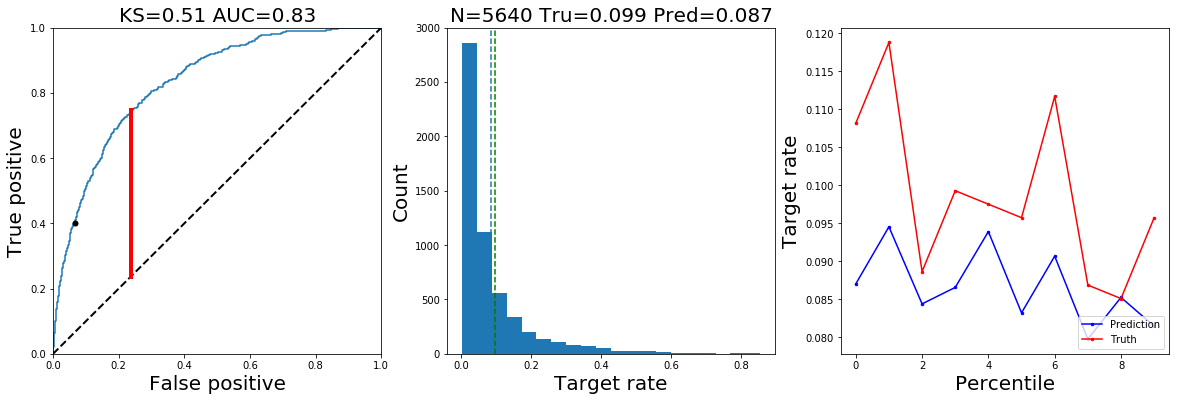

0.51018691162960561

In [7]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [8]:
selectNum = 200
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)

tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[:selectNum]
imp.sort_values('sum_imp',ascending=False)

,lk,variable,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,sum_imp
37,f37,age,0.039915,0.036377,0.044190,0.040056,0.040052,0.200590
518,f518,PartIII_3_based-PartV_3_based,0.006435,0.006249,0.005425,0.005873,0.007438,0.031421
715,f715,PartV_7_based-PartV_10_based,0.009286,0.006381,0.004988,0.003944,0.006294,0.030893
634,f634,PartV_1_based-PartV_8_based,0.005865,0.004868,0.006563,0.007626,0.005395,0.030316
105,f105,PartI_1_based-PartII_1_based,0.003014,0.005854,0.008488,0.005171,0.004414,0.026942
98,f98,PartI_1_based-PartI_2_based,0.006028,0.004736,0.007000,0.004733,0.004169,0.026666
194,f194,PartI_3_based-PartVI_1_based,0.003095,0.003355,0.008400,0.004032,0.007765,0.026648
213,f213,PartI_4_based-PartIII_3_based,0.005784,0.004342,0.003675,0.005960,0.004986,0.024747
223,f223,PartI_4_based-PartV_5_based,0.004888,0.003421,0.004550,0.006398,0.005313,0.024570
698,f698,PartV_6_based-PartV_7_based,0.004154,0.005526,0.006300,0.004645,0.003842,0.024468


In [ ]:
test_result,result,imp_selected = mm.xgb_kfold(dfTrain,dfPred,tmpPredictor,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.685987	eval-logloss:0.686313
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.331298	eval-logloss:0.360553
[200]	train-logloss:0.224236	eval-logloss:0.27821
[300]	train-logloss:0.177065	eval-logloss:0.253098
[400]	train-logloss:0.14926	eval-logloss:0.244649
[500]	train-logloss:0.13	eval-logloss:0.24134
[600]	train-logloss:0.114903	eval-logloss:0.240478


In [ ]:
mt.evaluate_performance(test_result['target'],test_result['score'])
imp.sort_values('sum_imp',ascending=False)

## 回归模型

In [ ]:
##将分类打分放入原始数据
dfTrain['scoreBinary'] = test_result['score']
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
dfPred['scoreBinary'] = result['score'].tolist()

predictorReg = predictors.copy()
predictorReg.append('scoreBinary')

dfTrain['Y'] = saveY

##将分数以rank形式保存一份
dfTrain['scoreBinaryPcent'] = dfTrain['scoreBinary'].rank()/float(dfTrain.shape[0])
dfPred['scoreBinaryPcent'] = dfPred['scoreBinary'].rank()/float(dfPred.shape[0])
predictorReg.append('scoreBinaryPcent')

In [ ]:
print(dfTrain['scoreBinary'].mean())
print(dfTrain['scoreBinary'].max())
print(dfTrain['scoreBinary'].min())
print('--------------')
print(dfPred['scoreBinary'].mean())
print(dfPred['scoreBinary'].max())
print(dfPred['scoreBinary'].min())

In [ ]:
predictorsRF = fs.RF_selection(dfTrain,predictorReg)
print(predictorsRF[:10])

In [ ]:
n_splits=5
early_stop=50
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'reg:linear','lambda':1,'subsample':0.8,'colsample_bytree':0.8}
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,predictorReg,n_splits,early_stop=early_stop,params=params)

In [ ]:
selectNum = 200
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)

tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[0:selectNum+1]
imp.sort_values('sum_imp',ascending=False)

In [ ]:
test_result,result,imp_selected = mm.xgb_kfold(dfTrain,dfPred,tmpPredictor,n_splits,early_stop=early_stop,params=params)

In [ ]:
for i in range(1,n_splits+1):
    imp_selected['imp_fold%d'%i] = imp_selected['imp_fold%d'%i]/imp_selected['imp_fold%d'%i].sum()
imp_selected['sum_imp'] = imp_selected[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)
imp_selected.sort_values('sum_imp',ascending=False).reset_index()

In [ ]:
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
print((result['score']>6.8).sum())
print(result['score'].min())
print(result['score'].max())
print(result['score'].mean())
print(result['score'].median())
print("-------------------------")
print(result.iloc[938,:])

In [ ]:
n_splits=5
other_note ='_classfier_first'
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
submit = result[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
result.to_csv('../../Submission/result/result_%s'%today+other_note+'.csv',index=False)
submit['score'].to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
test_result.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)
imp.to_csv('../../Submission/imp/importance_%s'%today+other_note+'.csv',index=False)